In [81]:
from Utils.Utils import *
from Utils.Blacksmith import * 

from Utils.HyMNet import HyMNet
from sklearn.svm import SVC
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import sklearn

In [26]:
def show_tensor(tensor):
    
    if torch.is_tensor(tensor):
        # if the image tensor is on GPU, move it to CPU
        tensor_image = tensor.cpu()

        # convert the tensor to a numpy array
        numpy_image = tensor_image.numpy()
    else:
        numpy_image = tensor

    # if the image has 3 channels, transpose it from CHW to HWC format
    if numpy_image.shape[0] == 3:
        numpy_image = np.transpose(numpy_image, (1, 2, 0))

    # display the image
    plt.imshow(numpy_image.squeeze())
    plt.show()

In [27]:
# Seed
set_seed(0)

In [28]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [29]:
PATH = "/home/baharoon/HTN/data/"
CSV_PATH = {"HTNPath": PATH + r"HTN", "NonHTNPath": PATH + "NonHTN"}

MODELS_PATH = "/home/baharoon/HTN/Models"

In [30]:
image_names = os.listdir(CSV_PATH["HTNPath"])
image_paths = [CSV_PATH["HTNPath"] + "/" + path for path in image_names]

In [31]:
BATCH_SIZE = 1
epochs = 50

image_size = 586
crop_size = 512

test_transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop(crop_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

resize_transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop(crop_size),
    T.ToTensor(),
])

test_dataset = HypertensionDataset(CSV_PATH, split="test", test_transform=test_transform)

/home/baharoon/HTN/HyMNet/Utils/Utils.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
FM_PATH = MODELS_PATH + r"/FundusModel.pth"
DM_PATH = MODELS_PATH + r"/DemographicFCNN.pth"

# Gradcam

In [ ]:
state_dict = torch.load(FM_PATH)
state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

image_model = get_retfound("/home/baharoon/HTN/RETFound_cfp_weights.pth", image_size=512, global_pool=True)
# image_model.head = torch.nn.Identity()

model = HyMNet(image_model=image_model).to(device)
model.load_state_dict(state_dict, strict=False)

In [ ]:
images = image_paths[:5]
images = [Image.open(image) for image in images]
torch_images = [test_transform(image) for image in images]
torch_images = torch.stack(torch_images).cuda()
images = [resize_transform(image) for image in images]

In [ ]:
def reshape_transform(tensor, height=32, width=32):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))

    # Bring the channels to the first dimension, like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

target_layers = [model.image_model.blocks[-1].norm1]
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform, use_cuda=True)

threshold = 0.25

# Use Grad-CAM to get the activation map
cam_data = cam(input_tensor=torch_images, aug_smooth=True)
cam_data[cam_data < threshold] = 0

In [208]:
for i in range(5):
    name = image_names[i].split(".")[0]
    grayscale_cam = (cam_data[i, :] * 255).astype(np.uint8)
    rgb_img = images[i].numpy()
    rgb_img_reshaped = np.transpose(rgb_img, (1, 2, 0))
    visualization = show_cam_on_image(rgb_img_reshaped, grayscale_cam, use_rgb=True)

    img = Image.fromarray(visualization)
    img.save(f'{name}_grayscale_cam.png')
    
    img = Image.fromarray( (255 * rgb_img_reshaped).astype('uint8'))
    img.save(f'{name}.png')

In [162]:
import seaborn as sns

def drawF1box(systems, colors):
    systems_f1s = {}
    for system in systems:
        f = open(os.getcwd() + '/Results/' + system + "preds" + ".json")
        data_json = json.load(f)
        trues, probs = data_json['true'], data_json['prob']
        
        f1_scores = []
        N = len(data_json['true'])
        
        system = "RETFound" if system == "FundusModel" else system
        system = "HyMNet" if system == "JointFusion" else system
        
        for i in range(N):
            preds = [1 if prob >= 0.5 else 0 for prob in probs[i]]
            f1_scores.append(sklearn.metrics.f1_score(trues[i], preds))
        systems_f1s[system] = f1_scores
    
    df = pd.DataFrame(systems_f1s)
    
    # Create a box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.title('Bootstrapped F1 Scores')
    plt.ylabel('F1 Score')
    plt.show()

In [163]:
systems = ['JointFusion', 'FundusModel', 'DemographicFCNN']
colors = {'JointFusion':'#EA4335', 'RETFound':'#4285F4', 'DemographicFCNN':'#34A853'}

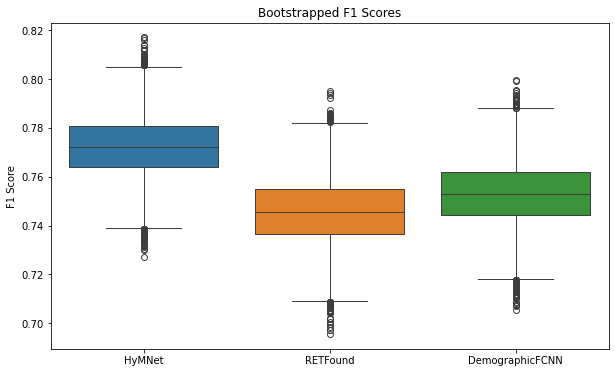

In [164]:
drawF1box(systems, colors)

In [165]:
def drawROCs(systems, colors):
    plt.title('Receiver Operating Characteristic (ROC)')
    for system in systems:
        f = open(os.getcwd() + '/Results/' + system + "preds" + ".json")
        data_json = json.load(f)
        trues, probs = data_json['true'], data_json['prob']
        
        auc_scores = []
        N = len(data_json['true'])
        
        for i in range(N):
            fpr, tpr, _ = roc_curve(trues[i], probs[i])
            auc_scores.append(auc(fpr, tpr))
                    
        lower = np.percentile(auc_scores, 2.5, method='nearest')
        upper = np.percentile(auc_scores, 97.5, method='nearest')
        median = np.percentile(auc_scores, 50, method='nearest')

        lower_index = auc_scores.index(lower)
        upper_index = auc_scores.index(upper)
        median_index = auc_scores.index(median)
        
        system = "RETFound" if system == "FundusModel" else system
        system = "HyMNet" if system == "JointFusion" else system

        trues_lower, probs_lower = trues[lower_index], probs[lower_index]
        trues_upper, probs_upper = trues[upper_index], probs[upper_index]
            
        fpr_lower, tpr_lower, threshold = roc_curve(trues_lower, probs_lower)
        cl = plt.plot(fpr_lower, tpr_lower, color=colors[system], alpha=0.25)   
        x = cl[0].get_xdata()
        
        fpr_upper, tpr_upper, threshold = roc_curve(trues_upper, probs_upper)
        cu = plt.plot(fpr_upper, tpr_upper, color=colors[system], alpha=0.25)   
            
        fpr_median, tpr_median, _ = roc_curve(trues[median_index], probs[median_index]) 
        auc_median = round(auc(fpr_median, tpr_median), 3)
        cm = plt.plot(fpr_median, tpr_median, label=f"Median {system} AUC: {auc_median}", color=colors[system])

        plt.fill(
            np.append(cu[0].get_xdata(), cl[0].get_xdata()[::-1]),
            np.append(cu[0].get_ydata(), cl[0].get_ydata()[::-1]),
            alpha=0.25
        )
        
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [166]:
def drawPRs(systems, colors):
    plt.title('Precision-Recall Curve (PR)')
    for system in systems:
        f = open(os.getcwd() + '/Results/' + system + "preds" + ".json")
        data_json = json.load(f)
        trues, probs = data_json['true'], data_json['prob']
        
        auc_scores = []
        N = len(data_json['true'])
        
        for i in range(N):
            precision, recall, _ = precision_recall_curve(trues[i], probs[i])
            auc_scores.append(auc(recall, precision))
               
        lower = np.percentile(auc_scores, 2.5, method='nearest')
        upper = np.percentile(auc_scores, 97.5, method='nearest')
        median = np.percentile(auc_scores, 50, method='nearest')

        lower_index = auc_scores.index(lower)
        upper_index = auc_scores.index(upper)
        median_index = auc_scores.index(median)
        
        system = "RETFound" if system == "FundusModel" else system
        system = "HyMNet" if system == "JointFusion" else system

        trues_lower, probs_lower = trues[lower_index], probs[lower_index]
        trues_upper, probs_upper = trues[upper_index], probs[upper_index]
            
        precision, recall, _ = precision_recall_curve(trues_lower, probs_lower)
        cl = plt.plot(recall, precision, color=colors[system], alpha=0.25)   
        x = cl[0].get_xdata()
        
        precision, recall, _ = precision_recall_curve(trues_upper, probs_upper)
        cu = plt.plot(recall, precision, color=colors[system], alpha=0.25)   
            
        precision, recall, _= precision_recall_curve(trues[median_index], probs[median_index]) 
        auc_median = round(auc(recall, precision), 3)
        cm = plt.plot(recall, precision, label=f"Median {system} AUC: {auc_median}", color=colors[system])

        plt.fill(
            np.append(cu[0].get_xdata(), cl[0].get_xdata()[::-1]),
            np.append(cu[0].get_ydata(), cl[0].get_ydata()[::-1]),
            alpha=0.25
        )
        
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

In [169]:
systems = ['JointFusion', 'FundusModel', 'DemographicFCNN']
colors = {'HyMNet':'#EA4335', 'RETFound':'#4285F4', 'DemographicFCNN':'#34A853'}

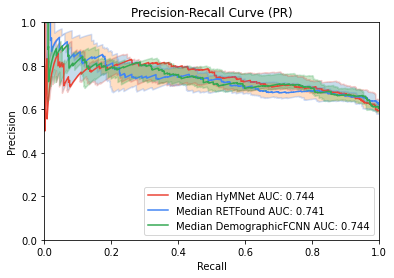

In [170]:
drawPRs(systems, colors)

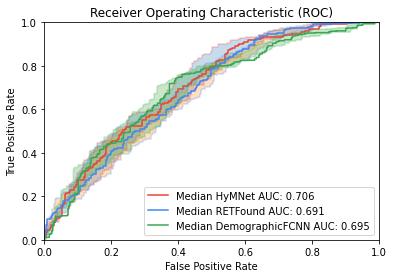

In [171]:
drawROCs(systems, colors)

In [22]:
systems = ['FeatureFusion', 'LateFusionFCNN', "VotingFusionFCNN"]
colors = {'FeatureFusion':'#4285F4', 'LateFusionFCNN':'#DB4437',
          "VotingFusionFCNN":"#0F9D58"}

FileNotFoundError: [Errno 2] No such file or directory: '/home/baharoon/HTN/HyMNet/Results/FeatureFusionpreds.json'

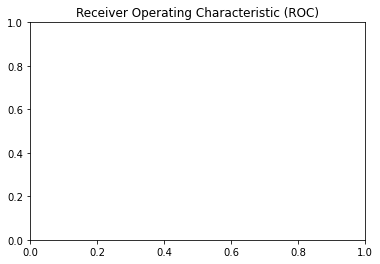

In [23]:
drawROCs(systems, colors)

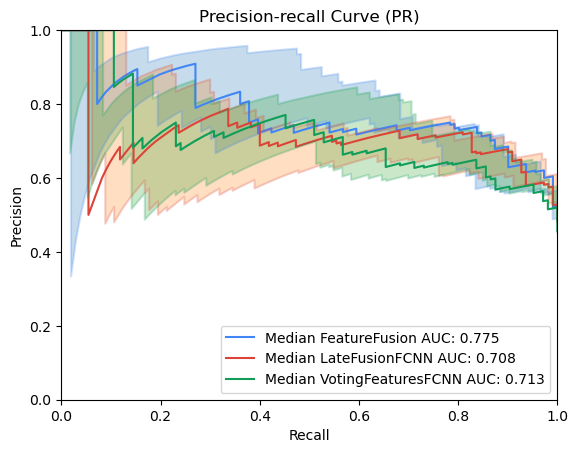

In [12]:
drawPRs(systems, colors)